In [24]:
"""
Visualization script for multi-run evaluation results.
Creates various plots to analyze system performance across multiple runs.
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
from typing import Optional, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_palette("Spectral")
# Set the default font family
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


def load_results(results_path: Path) -> pd.DataFrame:
    """Load the combined results CSV file."""
    df = pd.read_csv(results_path)
    df = df.sort_values(by='system_name', ascending=True)
    print(f"Loaded {len(df)} rows from {results_path}")
    print(f"Systems: {df['system_name'].unique()}")
    print(f"Runs per system: {df.groupby('system_name')['run'].nunique().to_dict()}")
    print(f"Queries: {df['query_name'].unique()}\n")
    return df


def generate_summary_table(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Generate and save a summary statistics table."""
    summary = df.groupby('system_name').agg({
        'quality': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(3)

    # Add count of runs and queries
    counts = df.groupby('system_name').agg({
        'run': 'nunique',
        'query_name': 'nunique'
    })
    counts.columns = ['n_runs', 'n_queries']

    # Combine into final summary
    final_summary = pd.concat([summary, counts], axis=1)

    print("\n" + "="*80)
    print("SUMMARY STATISTICS TABLE")
    print("="*80)
    print(final_summary.to_string())

    if save_path:
        final_summary.to_csv(save_path / 'summary_statistics.csv')
        print(f"\nSummary saved to {save_path / 'summary_statistics.csv'}")

    return final_summary

In [25]:
def plot_performance_scatter_comparison(df1: pd.DataFrame, df2: pd.DataFrame,
                                       subtitle1: str, subtitle2: str,
                                       horizontal_line: Optional[float] = None,
                                       vertical_line: Optional[float] = None,
                                       save_path: Optional[Path] = None):
    """Create side-by-side scatter plots showing quality vs latency trade-off with shared legend."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.rc('font', size=14)

    # Get all unique systems from both dataframes for consistent coloring
    all_systems = pd.concat([df1['system_name'], df2['system_name']]).unique()
    colors = sns.color_palette("husl", len(all_systems))
    color_map = dict(zip(all_systems, colors))

    # Function to plot on a single axis
    def plot_on_axis(ax, df, subtitle):
        if horizontal_line is not None:
            ax.axhline(y=horizontal_line, color='gray', linestyle='--', linewidth=1.5,
                      alpha=0.7, zorder=2)
        if vertical_line is not None:
            ax.axvline(x=vertical_line, color='gray', linestyle='--', linewidth=1.5,
                      alpha=0.7, zorder=2)

        systems = df['system_name'].unique()

        for system in systems:
            system_df = df[df['system_name'] == system]
            color = color_map[system]

            # Plot individual points
            ax.scatter(system_df['latency'], system_df['quality'],
                      label=system, alpha=0.6, s=50, color=color,
                      edgecolor='black', linewidth=0.5)

            # Add query labels for each point
            for idx, row in system_df.iterrows():
                query_label = row['query_name']
                if not query_label.startswith('Q'):
                    query_label = f"Q{query_label}"

                ax.annotate(query_label,
                          (row['latency'], row['quality']),
                          xytext=(3, 3),
                          textcoords='offset points',
                          fontsize=7,
                          alpha=0.7,
                          color=color)

            # Add mean point with larger marker
            mean_latency = system_df['latency'].mean()
            mean_quality = system_df['quality'].mean()
            ax.scatter(mean_latency, mean_quality,
                      s=200, color=color, marker='D', edgecolor='black', linewidth=2,
                      label=f'{system} (mean)', zorder=5)

        # Invert x-axis so lower latency (better) is on the right
        ax.invert_xaxis()
        ax.set_title(subtitle, fontsize=16, style='italic')
        ax.set_xlabel('Latency (s)', fontsize=12)
        ax.set_ylabel('Quality', fontsize=12)
        ax.grid(True, alpha=0.3)

    # Plot on both axes
    plot_on_axis(ax1, df1, subtitle1)
    plot_on_axis(ax2, df2, subtitle2)

    # Create shared legend
    # Get unique handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combine and deduplicate
    handles_labels = dict(zip(labels1 + labels2, handles1 + handles2))
    unique_labels = sorted(handles_labels.keys())
    unique_handles = [handles_labels[label] for label in unique_labels]

    # Remove individual legends
    ax1.legend().remove() if ax1.get_legend() else None
    ax2.legend().remove() if ax2.get_legend() else None

    # Add shared legend at top-right over the plots
    fig.legend(unique_handles, unique_labels,
          bbox_to_anchor=(0.5, 1.02), loc='lower center',
          borderaxespad=0, fontsize=13, frameon=True,
          fancybox=True, shadow=True, ncol=len(unique_labels))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

def plot_token_usage_stacked(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Plot token usage as stacked bars showing prompt vs completion tokens."""

    fig, ax = plt.subplots(figsize=(20, 10))

    # Calculate average tokens per question per system
    token_summary = df.groupby(['query_name', 'system_name']).agg({
        'input_tokens': 'mean',
        'output_tokens': 'mean'
    }).reset_index()

    # Pivot for easier plotting
    prompt_pivot = token_summary.pivot(index='query_name', columns='system_name', values='input_tokens')
    completion_pivot = token_summary.pivot(index='query_name', columns='system_name', values='output_tokens')

    # Create stacked bar chart
    x = np.arange(len(prompt_pivot.index))
    width = 0.15

    colors = sns.color_palette("husl", len(prompt_pivot.columns))

    for i, (system, color) in enumerate(zip(prompt_pivot.columns, colors)):
        # Bottom bars (prompt tokens)
        bars1 = ax.bar(x + i*width, prompt_pivot[system], width,
                      label=f'{system} (prompt)', color=color, alpha=0.6)

        # Top bars (completion tokens)
        bars2 = ax.bar(x + i*width, completion_pivot[system], width,
                      bottom=prompt_pivot[system], label=f'{system} (completion)',
                      color=color, alpha=0.9)

        # Add total labels on top
        for j, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            total = bar1.get_height() + bar2.get_height()
            if total > 0:
                ax.text(bar1.get_x() + bar1.get_width()/2., total,
                        f'{int(round(total))}', ha='center', va='bottom', fontsize=7)

    ax.set_xlabel('Query', fontsize=12)
    ax.set_ylabel('Average Tokens', fontsize=12)
    ax.set_title('Token Usage by Query and System (Prompt + Completion)',
                fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(prompt_pivot.columns) - 1) / 2)
    ax.set_xticklabels(prompt_pivot.index)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper center', ncol=2, fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_generation_calls(df: pd.DataFrame, save_path: Optional[Path] = None):
    """Plot average number of generation calls used by each system for each question."""

    # Check if column exists
    if 'num_generation_calls' not in df.columns:
        print("Warning: num_generation_calls column not found in dataframe. Skipping generation calls plot.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Calculate average generation calls per question per system
    calls_summary = df.groupby(['query_name', 'system_name']).agg({
        'num_generation_calls': ['mean', 'std', 'min', 'max']
    }).reset_index()
    calls_summary.columns = ['query_name', 'system_name', 'mean_calls', 'std_calls', 'min_calls', 'max_calls']

    # Get unique queries and systems
    queries = sorted(df['query_name'].unique())
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    # Set up x-axis positions
    x = np.arange(len(queries))
    width = 0.8 / len(systems)

    stacked = [691, 713, 1272] #TODO: for the first bar, make this a hue
    # Plot 1: Bar chart with error bars
    ax1 = axes[0]
    for i, (system, color) in enumerate(zip(systems, colors)):
        system_data = calls_summary[calls_summary['system_name'] == system]
        # Ensure data is in correct order matching queries
        means = []
        stds = []
        for query in queries:
            query_data = system_data[system_data['query_name'] == query]
            if not query_data.empty:
                means.append(query_data['mean_calls'].values[0])
                stds.append(query_data['std_calls'].values[0])
            else:
                means.append(0)
                stds.append(0)

        offset = (i - len(systems)/2 + 0.5) * width
        bars = ax1.bar(x + offset, means, width, yerr=stds, label=system, color=color,
                      alpha=0.8, edgecolor='black', linewidth=0.5, capsize=3)

        # Add value labels on bars
        for j, (bar, mean_val) in enumerate(zip(bars, means)):
            if mean_val > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{mean_val:.1f}', ha='center', va='bottom', fontsize=7)

    ax1.set_xlabel('Query', fontsize=12)
    ax1.set_ylabel('Average Number of Generation Calls', fontsize=12)
    ax1.set_title('Generation Calls by Query and System (with std deviation)', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(queries)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Heatmap showing generation calls
    ax2 = axes[1]

    # Pivot data for heatmap
    heatmap_data = calls_summary.pivot(index='query_name', columns='system_name', values='mean_calls')

    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
                ax=ax2, cbar_kws={'label': 'Avg Generation Calls'})
    ax2.set_title('Generation Calls Heatmap', fontsize=13, fontweight='bold')
    ax2.set_xlabel('System', fontsize=12)
    ax2.set_ylabel('Query', fontsize=12)

    plt.suptitle('LLM Generation Calls Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path / 'generation_calls.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\nGeneration Calls Summary:")
    print("="*60)
    overall_summary = df.groupby('system_name')['num_generation_calls'].agg([
        'mean', 'std', 'min', 'max', 'sum'
    ]).round(2)
    print(overall_summary)

    # Print detailed breakdown
    print("\nDetailed Generation Calls per System:")
    print("-"*40)
    for system in systems:
        system_df = df[df['system_name'] == system]
        total_calls = system_df['num_generation_calls'].sum()
        avg_calls = system_df['num_generation_calls'].mean()
        print(f"{system}:")
        print(f"  Total calls across all runs: {int(total_calls)}")
        print(f"  Average calls per query: {avg_calls:.2f}")
        print(f"  Min calls: {system_df['num_generation_calls'].min()}")
        print(f"  Max calls: {system_df['num_generation_calls'].max()}")


def plot_generation_calls_by_query(df: pd.DataFrame, figsize=(14,6), width=None, save_path: Optional[Path] = None):
    """Plot average number of generation calls for each query, grouped by system."""

    df['num_generation_calls'] = [int(x) for x in df['num_generation_calls']]

    fig, ax = plt.subplots(figsize=figsize)

    # Calculate average generation calls per query per system (averaged across runs)
    calls_summary = df.groupby(['query_name', 'system_name'])['num_generation_calls'].mean().reset_index()

    # Get unique queries and systems
    queries = sorted(df['query_name'].unique())
    systems = df['system_name'].unique()
    colors = sns.color_palette("husl", len(systems))

    # Set up x-axis positions
    x = np.arange(len(queries))
    if width is None:
        width = 0.8 / len(systems)

    # Create grouped bar chart
    for i, (system, color) in enumerate(zip(systems, colors)):
        system_data = calls_summary[calls_summary['system_name'] == system]

        # Get values in correct order matching queries
        values = []
        for query in queries:
            query_data = system_data[system_data['query_name'] == query]
            if not query_data.empty:
                values.append(int(query_data['num_generation_calls'].values[0]))
            else:
                values.append(0)

        offset = (i - len(systems)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=system, color=color,
                     alpha=0.8, edgecolor='black', linewidth=0.5)

        # Add value labels on bars
        for bar, val in zip(bars, values):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'{val}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Query', fontsize=12)
    ax.set_ylabel('# LM Generation Calls', fontsize=12)
    # ax.set_title('Generation Calls per Query by System', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(queries)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

In [26]:
import statistics

total_gemini_25_flash_costs = sum([
    0.087, 0.0051, 0.0049, 0.0050, 2.38, 1.81,  0.0040,
    0.00042, 0.0015, 0.0023, 0.0023, 0.0011, 0.00087, 0.0046
])
print(f"{total_gemini_25_flash_costs=}")

gemini_20_flash_costs = sum([
    0.027, 0.0016, 0.0015, 0.0016, 0.63, 0.67, 0.0013,
    0.00021, 0.00097, 0.00012, 0.00012, 0.00054, 0.00052, 0.0023
])
print(f"{gemini_20_flash_costs=}")

gpt_4o_mini_costs = sum([
    0.041, 0.0024, 0.0023, 0.0024, 0.62, 0.48, 0.0022,
    0.00021, 0.00058, 0.0012, 0.0012, 0.00069, 0.00053, 0.0023
])
print(f"{gpt_4o_mini_costs=}")

gpt_5_mini_costs = sum([
    0.11, 0.0065, 0.0064, 0.0064, 1.81, 0.0060,
    0.00073, 0.0021, 0.0042, 0.0042, 0.0012, 0.00095, 0.0083
])
print(f"{gpt_5_mini_costs=}")

print(f"Total thalamusdb + lotus costs: {total_gemini_25_flash_costs + gemini_20_flash_costs + gpt_4o_mini_costs + gpt_5_mini_costs}")

mean_quality = statistics.mean([1.0, 1.0, 0.64, 0.64, 0.59, 0.67, 0.93, 1.0, 1.0, 0.64, 0.74, 0.39, 0.83, 0.86, 0.74, 0.74, 0.83, 1.0, 1.0, 0.64, 0.64, 0.89, 0.69, 0.76])
mean_latency = statistics.mean([33.1, 2.1, 2.1, 2.8, 536.5, 432.4,  2.3, 3.8, 29.7, 4.6, 4.4, 1.9, 2.3, 4.3, 4.2, 1.9, 3.1, 3.8, 2.3, 1.7, 6.8, 26.3, 9.5, 11.0, 11.4, 54.5, 54.5, 10.9])

print(f"{mean_quality=}, {mean_latency=}")

total_gemini_25_flash_costs=4.30909
gemini_20_flash_costs=1.33778
gpt_4o_mini_costs=1.1570099999999999
gpt_5_mini_costs=1.96698
Total thalamusdb + lotus costs: 8.770859999999999
mean_quality=0.7858333333333334, mean_latency=45.15


In [14]:
statistics.mean([1, 0.6, 0.79, 0.79, 0.7, 0.5, 1, 0.83, 0.71])

0.7688888888888888

Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']

Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']



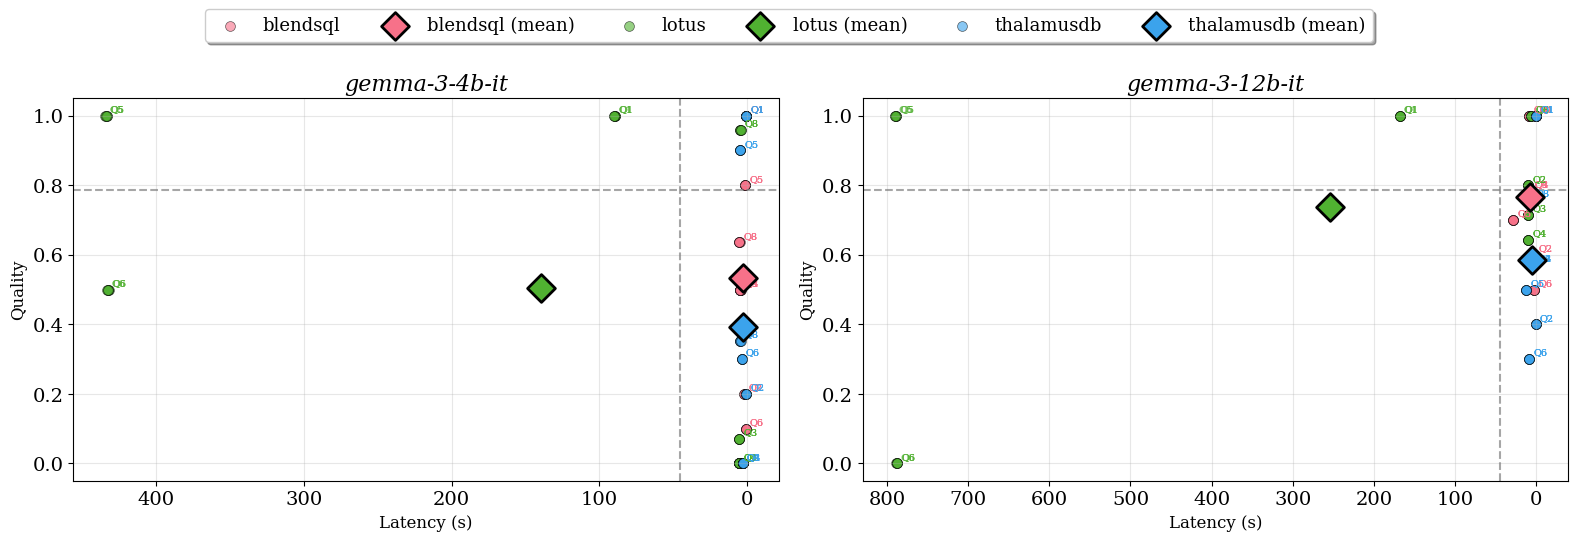

In [27]:
model_path_to_tag = (
    ["unsloth_gemma-3-4b-it-GGUF", "gemma-3-4b-it"],
    ["unsloth_gemma-3-12b-it-GGUF", "gemma-3-12b-it"],
)

dfs_to_plot = []
subtitles = []
for model_path, model_tag in model_path_to_tag:
    results_path = Path(f"results/2026-01-08/{model_path}/all_results_with_runs.csv")
    output_dir = results_path.parent / "visualizations"
    if not output_dir.is_dir():
        output_dir.mkdir()
    # Load data
    df = load_results(results_path)
    df = df[df['system_name'] != 'palimpzest']
   
    common_queries = df.groupby('query_name')['system_name'].nunique()[lambda x: x == df['system_name'].nunique()].index.tolist()
    dfs_to_plot.append(df[df['query_name'].isin(common_queries)])
    subtitles.append(model_tag)

plot_performance_scatter_comparison(
    *dfs_to_plot,
    *subtitles,
    horizontal_line=mean_quality,
    vertical_line=mean_latency,
    save_path=f"performance_latency_scatter_gemma-3.pdf",
)

In [40]:
df = load_results(f"results/2026-01-08/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv")

Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']



In [31]:
metrics_to_analyze = [
    'latency',
    'quality',
    # 'output_tokens',
    # 'input_tokens'
]
summary_df = pd.DataFrame()
for metric in metrics_to_analyze:
    temp = df.groupby(['system_name', 'query_name'])[metric].agg(['mean', 'std'])
    temp.columns = [f'{metric}_mean', f'{metric}_std']
    if summary_df.empty:
        summary_df = temp
    else:
        summary_df = summary_df.join(temp)

# Format the output with std in parentheses only for latency
formatted_df = pd.DataFrame(index=summary_df.index)

# Format latency with std in parentheses
formatted_df['latency'] = summary_df.apply(
    lambda row: f"{row['latency_mean']:.3f} (±{row['latency_std']:.3f})"
    if pd.notna(row['latency_std'])
    else f"{row['latency_mean']:.3f}",
    axis=1
)

formatted_df['quality'] = summary_df.apply(
    lambda row: f"{row['quality_mean']:.3f} (±{row['quality_std']:.3f})"
    if pd.notna(row['quality_std'])
    else f"{row['quality_mean']:.3f}",
    axis=1
)

# Keep quality as simple numeric values
# formatted_df['quality'] = summary_df['quality_mean'].round(3)

print(formatted_df)

                                 latency         quality
system_name query_name                                  
blendsql    Q1            0.886 (±0.001)  1.000 (±0.000)
            Q10         127.374 (±1.894)  0.708 (±0.000)
            Q11           3.453 (±0.077)  0.941 (±0.000)
            Q12          40.955 (±0.847)  1.000 (±0.000)
            Q2            3.051 (±0.063)  0.600 (±0.000)
            Q3            7.611 (±0.141)  0.786 (±0.000)
            Q4            7.351 (±0.143)  0.786 (±0.000)
            Q5           28.446 (±0.046)  0.700 (±0.000)
            Q6            3.134 (±0.005)  0.500 (±0.000)
            Q8            8.847 (±0.208)  1.000 (±0.000)
            Q9           10.048 (±0.181)  0.825 (±0.000)
lotus       Q1          168.231 (±0.096)  1.000 (±0.000)
            Q10         181.326 (±0.086)  0.707 (±0.000)
            Q2            9.964 (±0.025)  0.800 (±0.000)
            Q3            9.858 (±0.021)  0.714 (±0.000)
            Q4            9.896

In [8]:
df[df['query_name'].isin(common_queries)].groupby("system_name")['latency'].agg(['mean', 'std'])

,mean,std
system_name,,
blendsql,8.475050,8.716053
lotus,254.478657,346.965875
thalamusdb,5.383725,3.939549


In [30]:
df[df['query_name'].isin(["Q11", "Q12"])].groupby("system_name")['quality'].agg(['mean', 'std'])

,mean,std
system_name,,
blendsql,0.970588,0.031003
thalamusdb,0.575000,0.079057


Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']



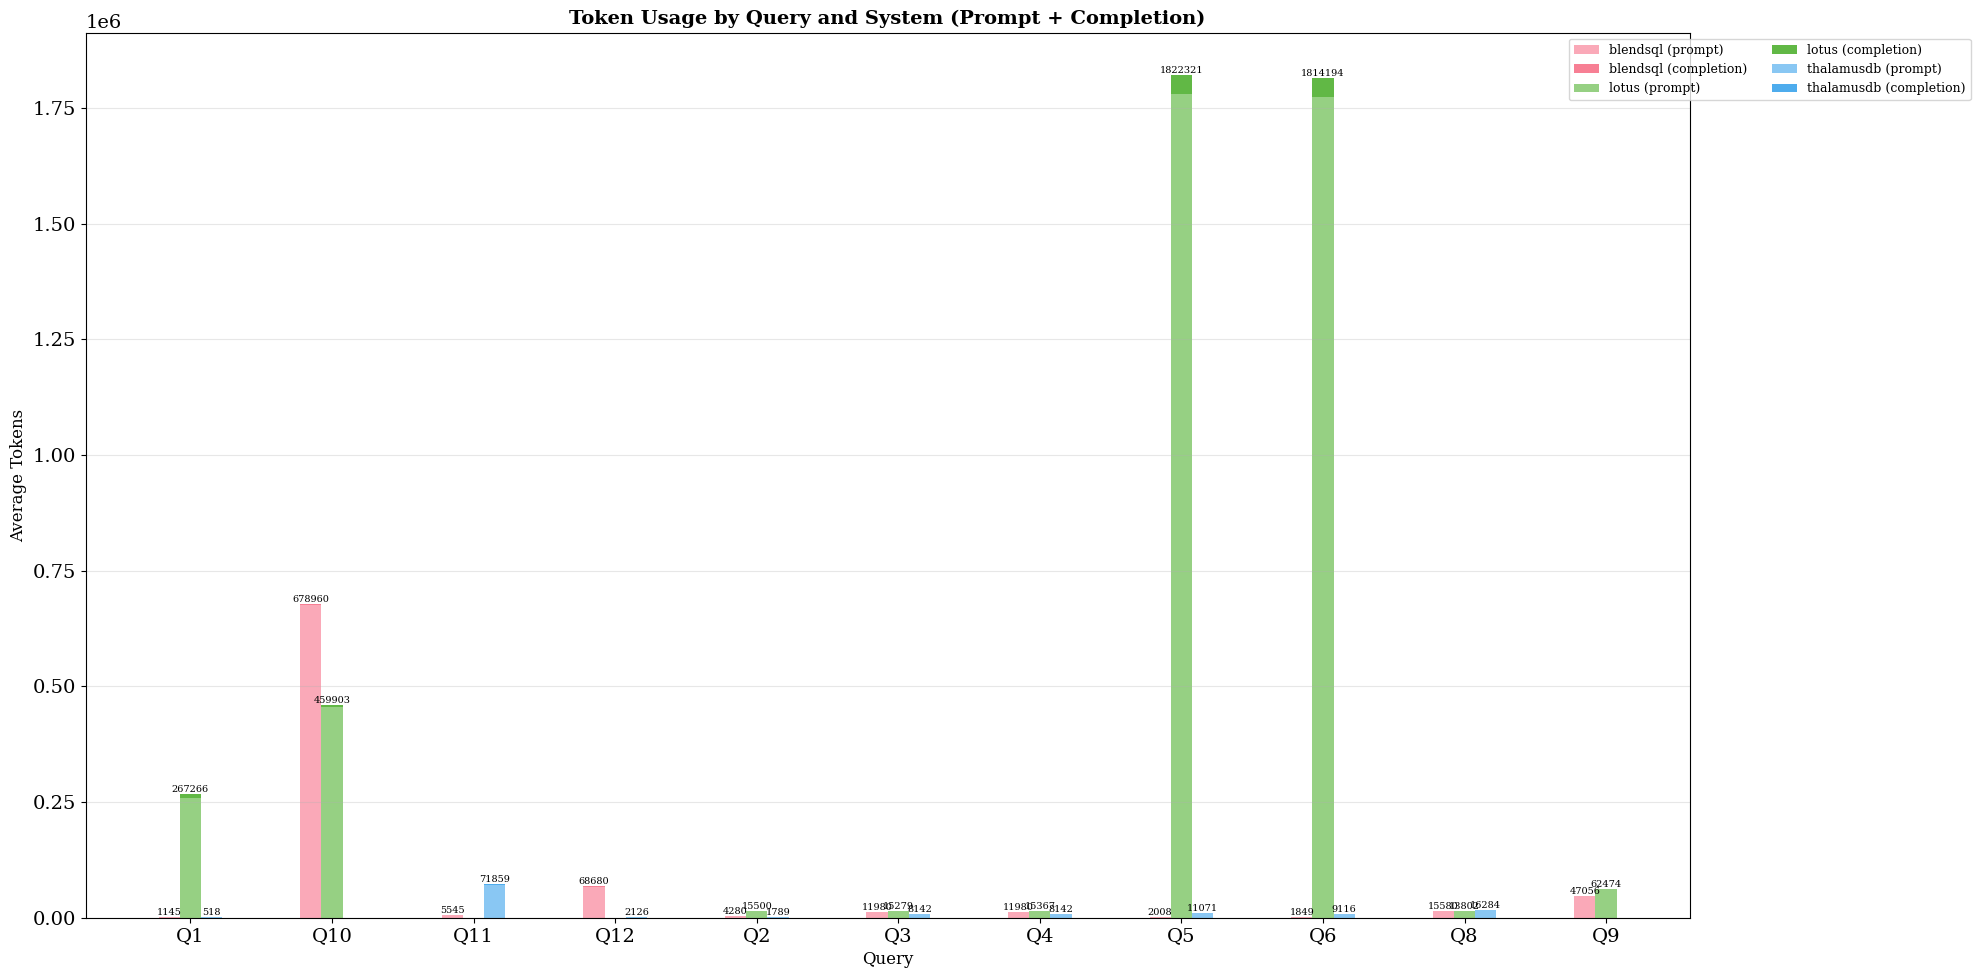

In [12]:
plot_token_usage_stacked(df, save_path="token_usage.png")

In [15]:
df = load_results(f"results/2026-01-08/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv")

Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-4b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']



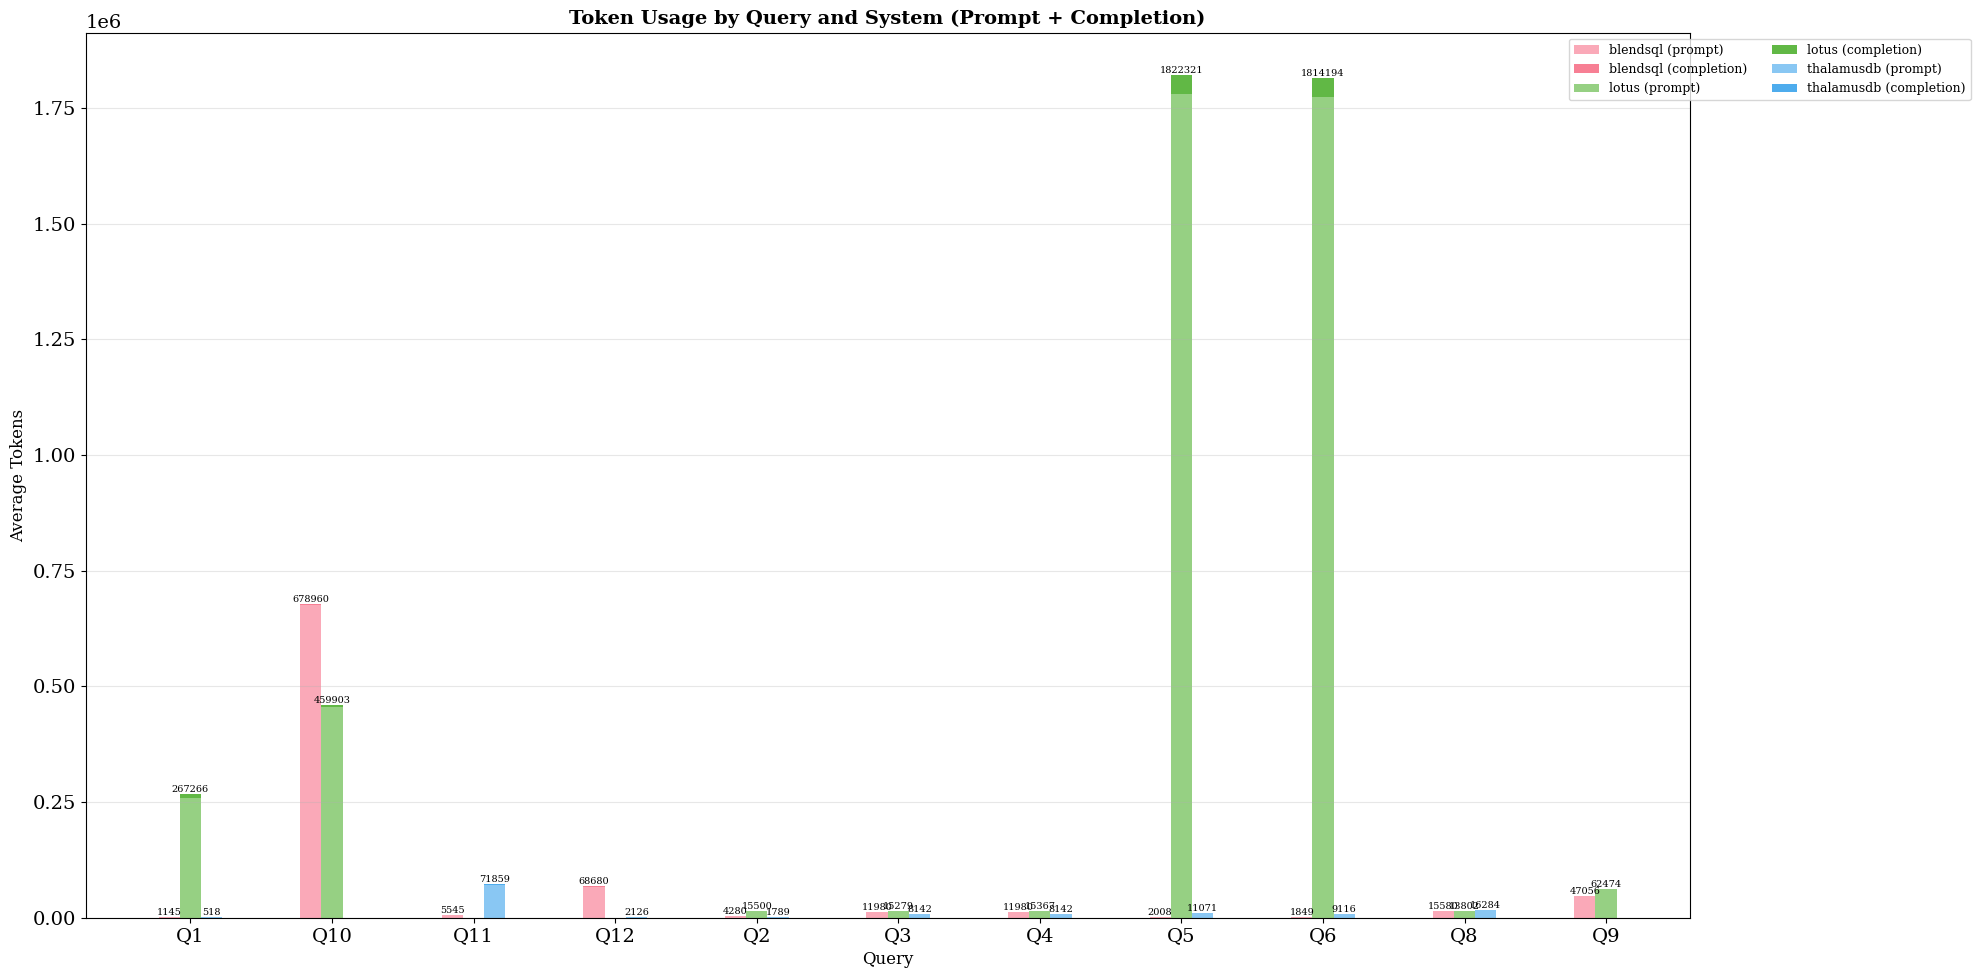

In [16]:
plot_token_usage_stacked(df, save_path="token_usage.png")

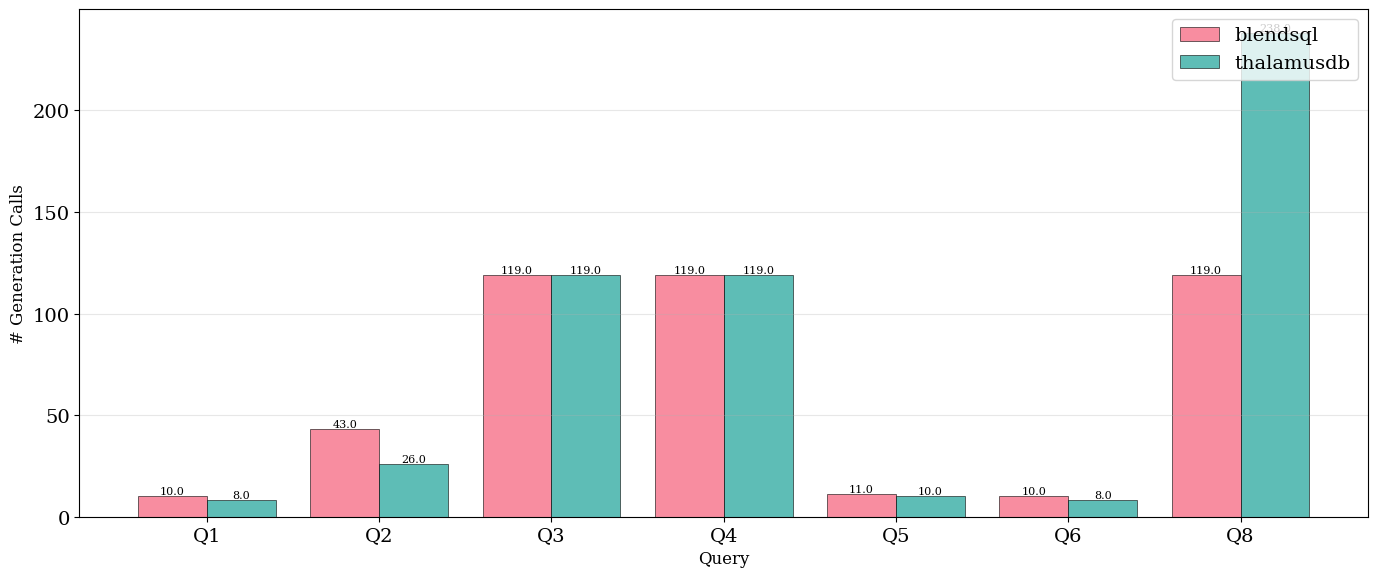

In [17]:
plot_generation_calls_by_query(df[(df['system_name'].isin(['thalamusdb', 'blendsql'])) & (df['query_name'].isin(common_queries))])

In [22]:
df = load_results(f"results/2026-01-08/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv")

Loaded 145 rows from results/2026-01-08/unsloth_gemma-3-12b-it-GGUF/all_results_with_runs.csv
Systems: ['blendsql' 'lotus' 'thalamusdb']
Runs per system: {'blendsql': 5, 'lotus': 5, 'thalamusdb': 5}
Queries: ['Q1' 'Q6' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q2' 'Q3' 'Q4' 'Q5']



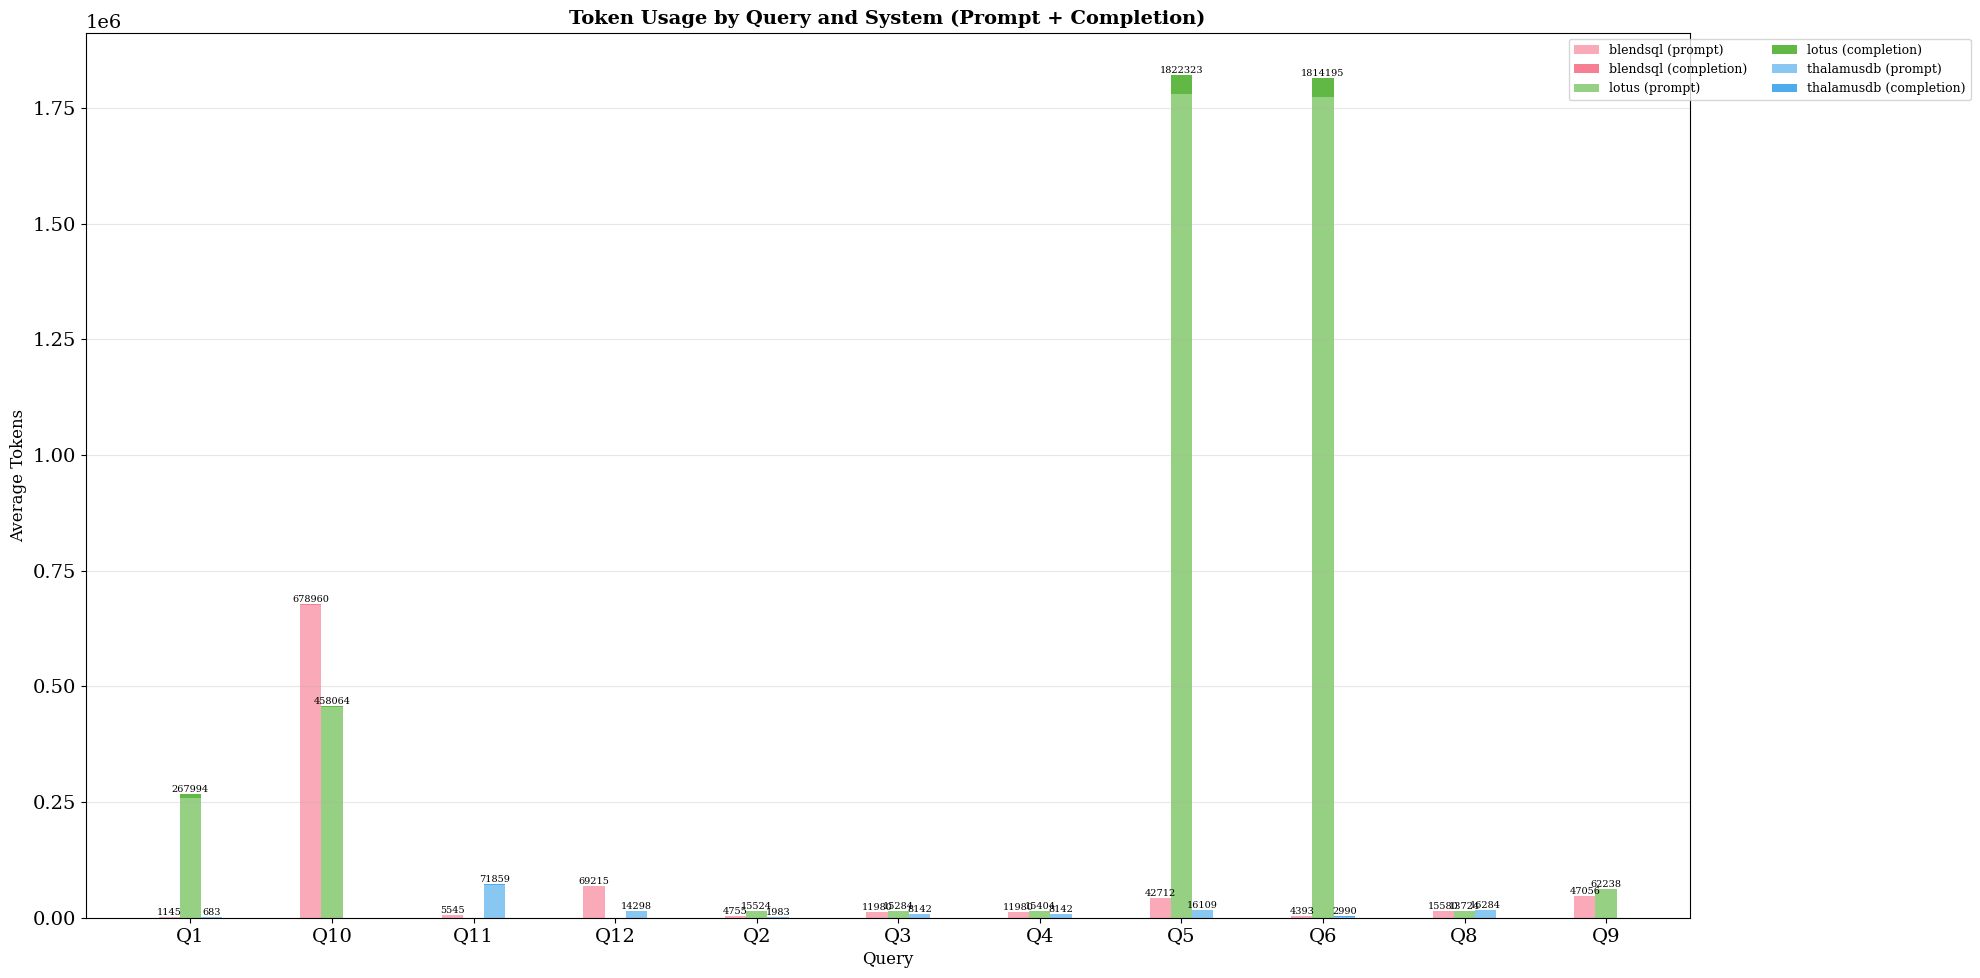

In [20]:
plot_token_usage_stacked(df, save_path="token_usage.png")

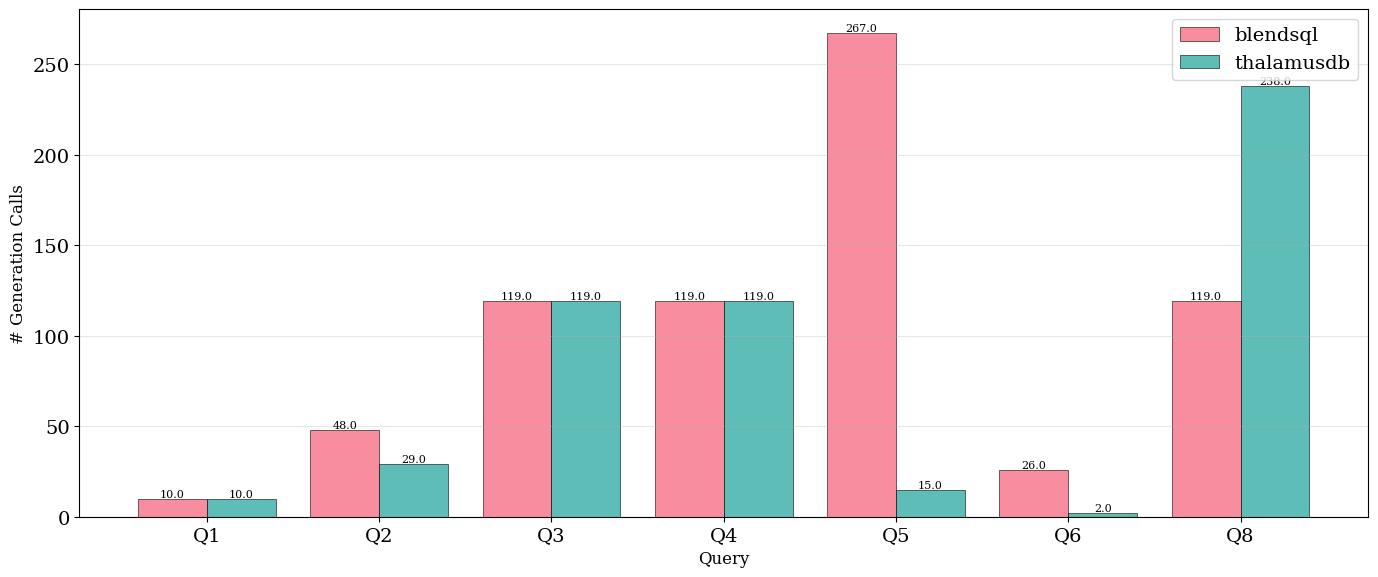

In [19]:
plot_generation_calls_by_query(df[(df['system_name'].isin(['thalamusdb', 'blendsql'])) & (df['query_name'].isin(common_queries))])

In [39]:
import altair as alt

def plot_generation_calls_by_query(
    df: pd.DataFrame,
    figsize=(14, 6),
    width=None,
    save_path: Optional[Path] = None
):
    """Plot average number of generation calls for each query, grouped by system using Altair."""

    df = df.copy()
    df['num_generation_calls'] = [int(x) for x in df['num_generation_calls']]

    # Calculate average generation calls per query per system (averaged across runs)
    calls_summary = df.groupby(['query_name', 'system_name'])['num_generation_calls'].mean().reset_index()
    calls_summary['num_generation_calls'] = calls_summary['num_generation_calls'].astype(int)

    # Get unique queries and systems
    queries = sorted(df['query_name'].unique())
    # Define explicit color mapping
    systems = list(df['system_name'].unique())  # e.g., ['thalamusdb', 'blendsql']
    colors = ['#f77189', '#3ba3ec']  # Your chosen colors

    # Convert figsize (inches) to pixels (assuming ~80 pixels per inch for web display)
    chart_width = int(figsize[0] * 50)
    chart_height = int(figsize[1] * 50)

    # Create the grouped bar chart
    bars = alt.Chart(calls_summary).mark_bar(
        cornerRadiusTopLeft=4,
        cornerRadiusTopRight=4,
        stroke='black',
        strokeWidth=0.5,
        opacity=0.8
    ).encode(
        x=alt.X('query_name:N',
                title='Query',
                sort=queries,
                axis=alt.Axis(labelAngle=-45)),
        xOffset=alt.XOffset('system_name:N', sort=systems),
        y=alt.Y('num_generation_calls:Q',
                title='# LM Generation Calls'),
        color=alt.Color('system_name:N',
                   title='System',
                   scale=alt.Scale(domain=systems, range=colors),
                   legend=alt.Legend(
                       orient='none',
                       legendX=chart_width - 83,  # Position from left
                       legendY=0,  # Position from top
                       fillColor='rgba(255, 255, 255, 0.9)',
                       strokeColor='#cccccc',
                       padding=10,
                       cornerRadius=2,
                   ))
    )

    # Add value labels on bars
    labels = alt.Chart(calls_summary).mark_text(
        dy=-5,
        fontSize=8
    ).encode(
        x=alt.X('query_name:N', sort=queries),
        xOffset=alt.XOffset('system_name:N', sort=systems),
        y=alt.Y('num_generation_calls:Q'),
        text=alt.Text('num_generation_calls:Q', format='d'),
        color=alt.value('black')
    )

    chart = (bars + labels).properties(
        width=chart_width,
        height=chart_height
    ).configure(
        font='serif'  # Use generic 'serif' for better PDF compatibility
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=12,
        labelFont='serif',
        titleFont='serif',
        grid=True,
        gridOpacity=0.3
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=10,
        labelFont='serif',
        titleFont='serif',
    ).configure_title(
        font='serif'
    )

    if save_path:
        # Save as SVG first, then convert to PDF for proper text embedding
        save_path = Path(save_path)
        if save_path.suffix.lower() == '.pdf':
            svg_path = save_path.with_suffix('.svg')
            chart.save(str(svg_path))
            # Convert SVG to PDF using cairosvg (pip install cairosvg)
            import cairosvg
            cairosvg.svg2pdf(url=str(svg_path), write_to=str(save_path))
            svg_path.unlink()  # Remove temporary SVG
        else:
            chart.save(str(save_path))

    return chart

In [40]:
plot_generation_calls_by_query(
    df[(df['system_name'].isin(['thalamusdb', 'blendsql'])) & (df['query_name'].isin(["Q11", "Q12"]))],
    figsize=(4, 4),
    width=0.1,
    save_path="Q11_Q12_gen_calls.pdf"
)

alt.LayerChart(...)

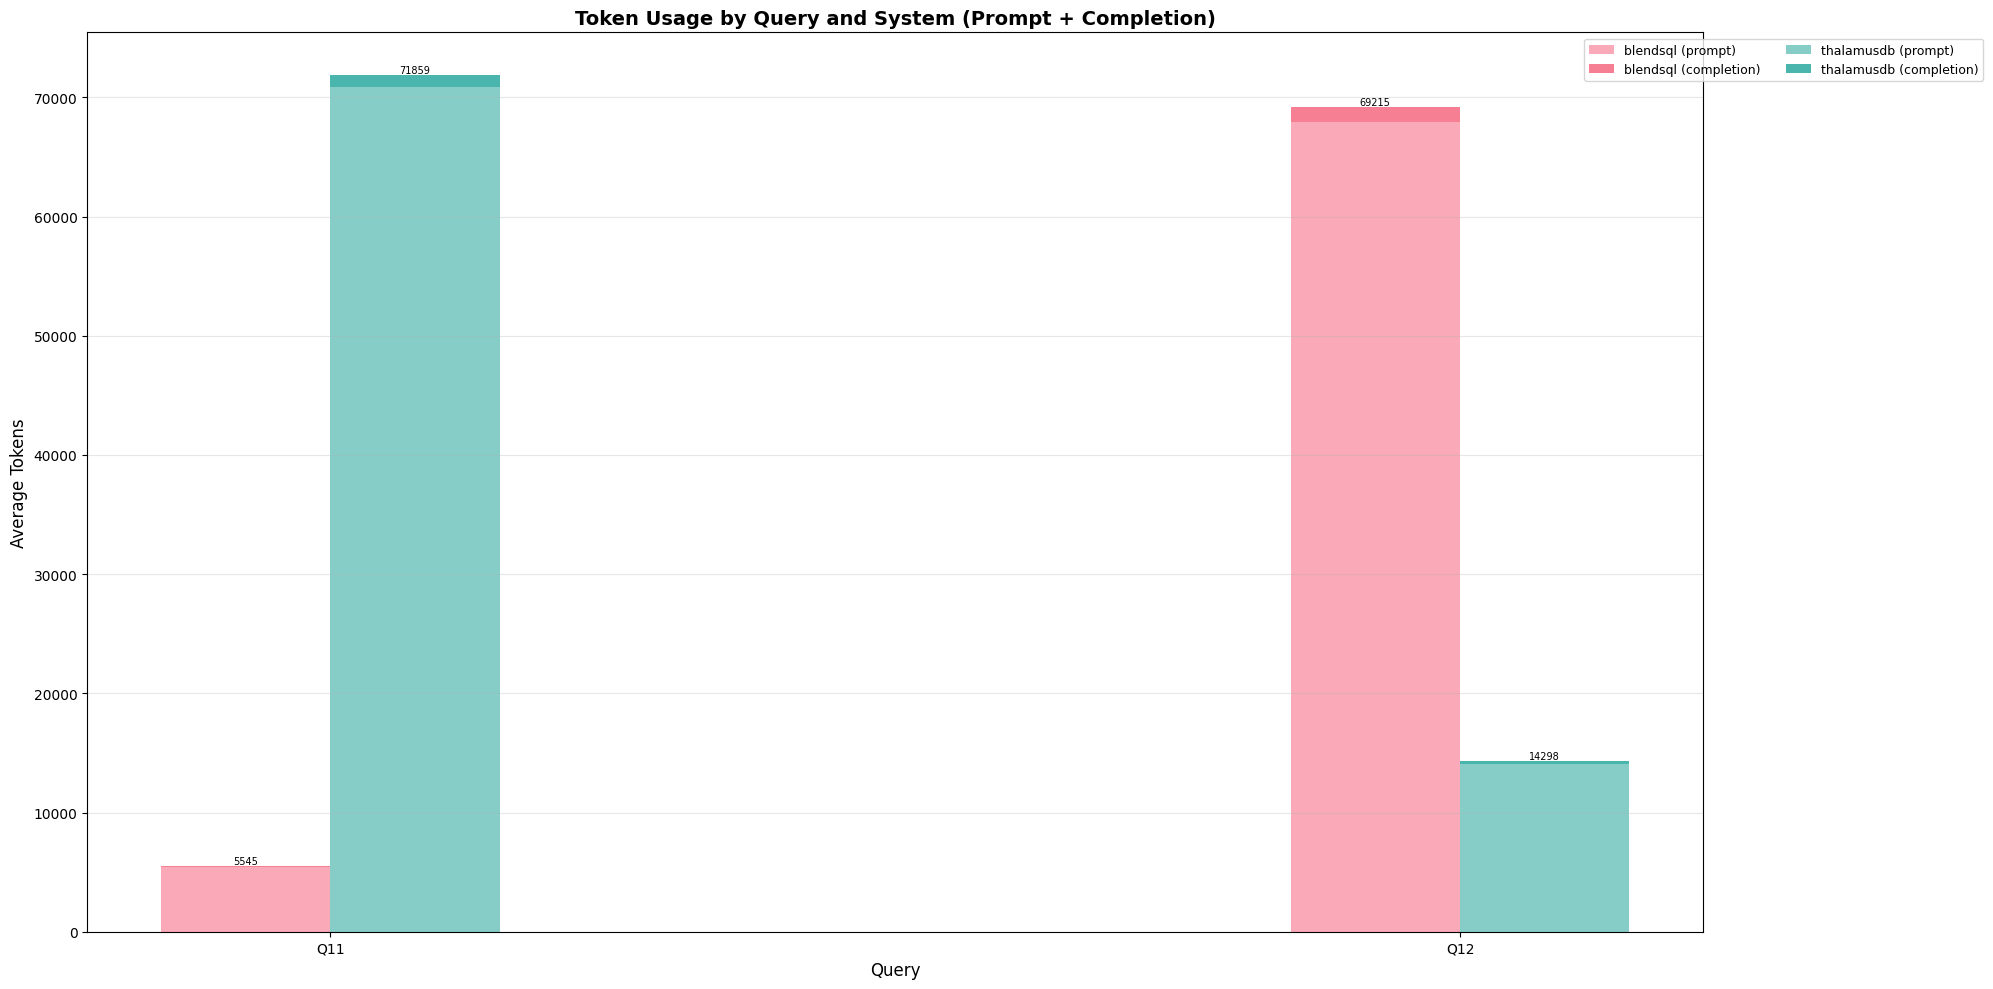

In [22]:
plot_token_usage_stacked(df[(df['system_name'].isin(['thalamusdb', 'blendsql'])) & (df['query_name'].isin(["Q11", "Q12"]))])

In [9]:
# Tests for Q11 and Q12
df = load_results(f"results/base/all_results_with_runs.csv")

metrics_to_analyze = [
    'latency',
    'quality',
    # 'output_tokens',
    # 'input_tokens'
]
summary_df = pd.DataFrame()
for metric in metrics_to_analyze:
    temp = df.groupby(['system_name', 'query_name'])[metric].agg(['mean', 'std'])
    temp.columns = [f'{metric}_mean', f'{metric}_std']
    if summary_df.empty:
        summary_df = temp
    else:
        summary_df = summary_df.join(temp)

# Format the output with std in parentheses only for latency
formatted_df = pd.DataFrame(index=summary_df.index)

# Format latency with std in parentheses
formatted_df['latency'] = summary_df.apply(
    lambda row: f"{row['latency_mean']:.3f} (±{row['latency_std']:.3f})"
    if pd.notna(row['latency_std'])
    else f"{row['latency_mean']:.3f}",
    axis=1
)

# Keep quality as simple numeric values
formatted_df['quality'] = summary_df['quality_mean'].round(3)

print(formatted_df)

Loaded 3 rows from results/base/all_results_with_runs.csv
Systems: ['blendsql']
Runs per system: {'blendsql': 3}
Queries: ['Q12']

                                latency  quality
system_name query_name                          
blendsql    Q12         46.551 (±0.588)    0.667


In [5]:
tdb = load_results(f"results/paper/blendsql-ablations-q12/tdb/all_results_with_runs.csv")

base = load_results(f"results/paper/blendsql-ablations-q12/base/all_results_with_runs.csv")
base_q11 = load_results(f"results/paper/blendsql-ablations-q12/base_q11/all_results_with_runs.csv")
ablation1 = load_results(f"results/paper/blendsql-ablations-q12/no-early-exit/all_results_with_runs.csv")
ablation2 = load_results(f"results/paper/blendsql-ablations-q12/nothing/all_results_with_runs.csv")

Loaded 6 rows from results/paper/blendsql-ablations-q12/tdb/all_results_with_runs.csv
Systems: ['thalamusdb']
Runs per system: {'thalamusdb': 3}
Queries: ['Q11' 'Q12']

Loaded 3 rows from results/paper/blendsql-ablations-q12/base/all_results_with_runs.csv
Systems: ['blendsql']
Runs per system: {'blendsql': 3}
Queries: ['Q12']

Loaded 3 rows from results/paper/blendsql-ablations-q12/base_q11/all_results_with_runs.csv
Systems: ['blendsql']
Runs per system: {'blendsql': 3}
Queries: ['Q11']

Loaded 3 rows from results/paper/blendsql-ablations-q12/no-early-exit/all_results_with_runs.csv
Systems: ['blendsql']
Runs per system: {'blendsql': 3}
Queries: ['Q12']

Loaded 3 rows from results/paper/blendsql-ablations-q12/nothing/all_results_with_runs.csv
Systems: ['blendsql']
Runs per system: {'blendsql': 3}
Queries: ['Q12']


In [12]:
metrics_to_analyze = [
    'latency',
    'quality',
    # 'output_tokens',
    # 'input_tokens'
]
df = tdb
summary_df = pd.DataFrame()
for metric in metrics_to_analyze:
    temp = df.groupby(['system_name', 'query_name'])[metric].agg(['mean', 'std'])
    temp.columns = [f'{metric}_mean', f'{metric}_std']
    if summary_df.empty:
        summary_df = temp
    else:
        summary_df = summary_df.join(temp)

# Format the output with std in parentheses only for latency
formatted_df = pd.DataFrame(index=summary_df.index)

# Format latency with std in parentheses
formatted_df['latency'] = summary_df.apply(
    lambda row: f"{row['latency_mean']:.3f} (±{row['latency_std']:.3f})"
    if pd.notna(row['latency_std'])
    else f"{row['latency_mean']:.3f}",
    axis=1
)

# Keep quality as simple numeric values
formatted_df['quality'] = summary_df['quality_mean'].round(3)

print(formatted_df)

                                latency  quality
system_name query_name                          
thalamusdb  Q11         37.958 (±0.168)     0.65
            Q12         40.590 (±0.062)     0.00


In [12]:
pd.concat([tdb, base, base_q11])

,system_name,query_name,latency,prediction,num_generation_calls,output_tokens,input_tokens,run,metrics,raw_metrics,quality
0,thalamusdb,Q11,38.128886,"{""columns"":[""reviewid""],""data"":[[2625197],[266...",1001,1001,70858,1,NaN,"{'precision': 1.0, 'recall': 0.481481481481481...",0.650000
1,thalamusdb,Q12,40.661802,"{""columns"":[""reviewid""],""data"":[]}",1002,1002,75206,1,NaN,"{'precision': 0.0, 'recall': 0.0, 'f1_score': ...",0.000000
2,thalamusdb,Q11,37.793565,"{""columns"":[""reviewid""],""data"":[[2625197],[266...",1001,1001,70858,2,NaN,"{'precision': 1.0, 'recall': 0.481481481481481...",0.650000
3,thalamusdb,Q12,40.553887,"{""columns"":[""reviewid""],""data"":[]}",1002,1002,75206,2,NaN,"{'precision': 0.0, 'recall': 0.0, 'f1_score': ...",0.000000
4,thalamusdb,Q11,37.952679,"{""columns"":[""reviewid""],""data"":[[2625197],[266...",1001,1001,70858,3,NaN,"{'precision': 1.0, 'recall': 0.481481481481481...",0.650000
5,thalamusdb,Q12,40.553519,"{""columns"":[""reviewid""],""data"":[]}",1002,1002,75206,3,NaN,"{'precision': 0.0, 'recall': 0.0, 'f1_score': ...",0.000000
0,blendsql,Q12,45.798827,"{""columns"":[""reviewId""],""data"":[[2601463],[256...",691,1382,73662,1,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.000000
1,blendsql,Q12,44.511795,"{""columns"":[""reviewId""],""data"":[[2601463],[256...",691,1382,73662,2,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.000000
2,blendsql,Q12,44.523569,"{""columns"":[""reviewId""],""data"":[[2601463],[256...",691,1382,73662,3,NaN,"{'precision': 1.0, 'recall': 1.0, 'f1_score': ...",1.000000
0,blendsql,Q11,4.095525,"{""columns"":[""reviewId""],""data"":[[2672549],[262...",54,108,5492,1,NaN,"{'precision': 1.0, 'recall': 0.796296296296296...",0.886598


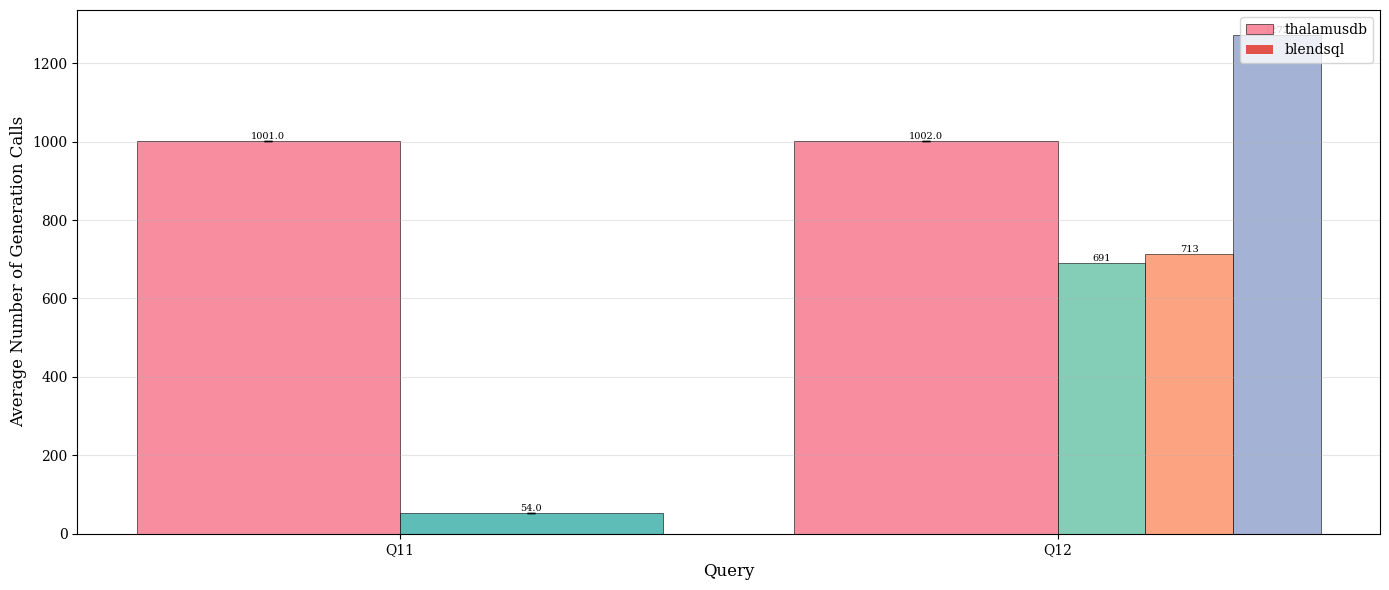

In [25]:
save_path = 'test.pdf'
df = pd.concat([tdb, base, base_q11])
"""Plot average number of generation calls used by each system for each question."""

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Calculate average generation calls per question per system
calls_summary = df.groupby(['query_name', 'system_name']).agg({
    'num_generation_calls': ['mean', 'std', 'min', 'max']
}).reset_index()
calls_summary.columns = ['query_name', 'system_name', 'mean_calls', 'std_calls', 'min_calls', 'max_calls']

# Get unique queries and systems
queries = sorted(df['query_name'].unique())
systems = df['system_name'].unique()
colors = sns.color_palette("husl", len(systems))

# Stacked values for blendsql Q12
stacked = [691, 713, 1272]
stacked_labels = ['Stack 1', 'Stack 2', 'Stack 3']  # You can customize these labels
stacked_colors = sns.color_palette("Set2", len(stacked))

# Set up x-axis positions
x = np.arange(len(queries))
width = 0.8 / len(systems)

# Plot bar chart with error bars
for i, (system, color) in enumerate(zip(systems, colors)):
    system_data = calls_summary[calls_summary['system_name'] == system]
    # Ensure data is in correct order matching queries
    means = []
    stds = []
    for query in queries:
        query_data = system_data[system_data['query_name'] == query]
        if not query_data.empty:
            means.append(query_data['mean_calls'].values[0])
            stds.append(query_data['std_calls'].values[0])
        else:
            means.append(0)
            stds.append(0)

    offset = (i - len(systems)/2 + 0.5) * width

    # Check if this is blendsql and handle Q12 specially
    if system == 'blendsql':
        for j, (query, mean_val, std_val) in enumerate(zip(queries, means, stds)):
            if query == 'Q12':
                # Plot stacked values for Q12 with different hues
                bar_width = width / len(stacked)
                for k, (stack_val, stack_label, stack_color) in enumerate(zip(stacked, stacked_labels, stacked_colors)):
                    stack_offset = offset + (k - len(stacked)/2 + 0.5) * bar_width
                    bar = ax.bar(x[j] + stack_offset, stack_val, bar_width,
                                label=f'{stack_label} (Q12)' if i == 0 and k == 0 else "",
                                color=stack_color, alpha=0.8, edgecolor='black', linewidth=0.5)
                    # Add value label on bar
                    ax.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(),
                           f'{stack_val}', ha='center', va='bottom', fontsize=7)
            else:
                # Regular bar for other queries
                bar = ax.bar(x[j] + offset, mean_val, width, yerr=std_val,
                            color=color, alpha=0.8, edgecolor='black', linewidth=0.5, capsize=3)
                if mean_val > 0:
                    ax.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(),
                           f'{mean_val:.1f}', ha='center', va='bottom', fontsize=7)
        # Add label for blendsql only once
        ax.bar([], [], width, label=system, color=color, alpha=0.8)
    else:
        # Regular bars for other systems
        bars = ax.bar(x + offset, means, width, yerr=stds, label=system, color=color,
                     alpha=0.8, edgecolor='black', linewidth=0.5, capsize=3)

        # Add value labels on bars
        for j, (bar, mean_val) in enumerate(zip(bars, means)):
            if mean_val > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'{mean_val:.1f}', ha='center', va='bottom', fontsize=7)

ax.set_xlabel('Query', fontsize=12)
ax.set_ylabel('Average Number of Generation Calls', fontsize=12)
# ax.set_title('Generation Calls by Query and System (with std deviation)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(queries)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

plt.show()


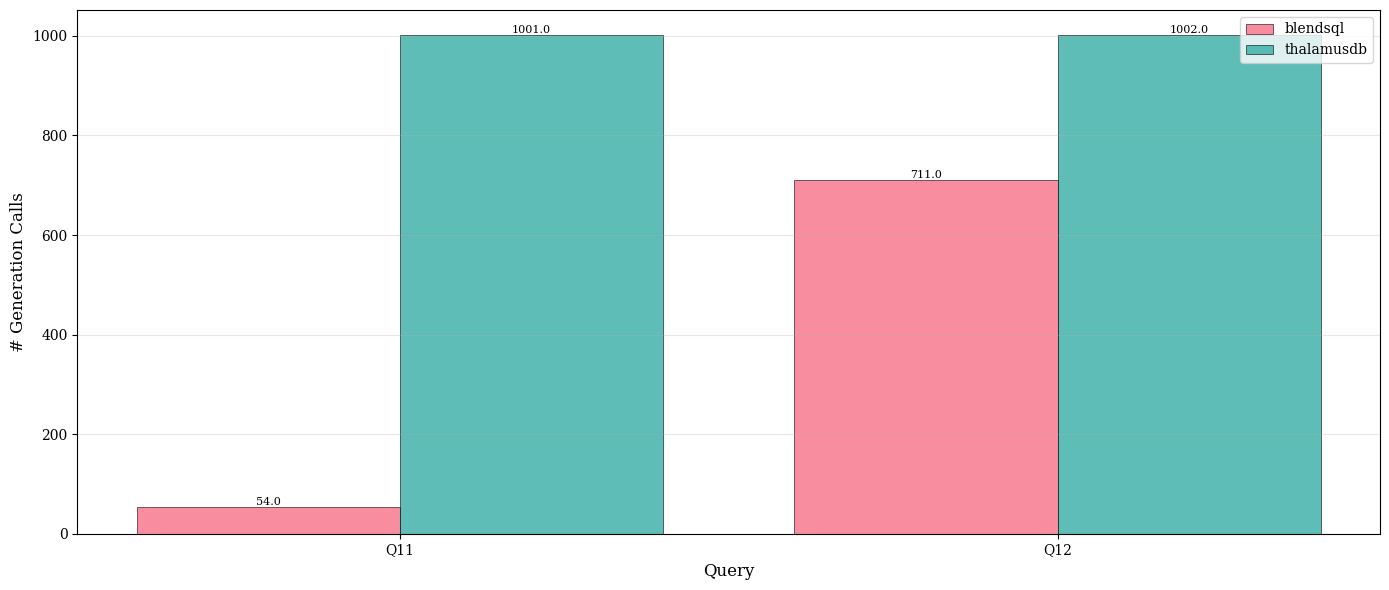

In [14]:
plot_generation_calls_by_query(df, 'gen_calls.pdf')

In [10]:
df[['system_name', 'query_name', 'latency', 'quality']].to_dict(orient='records')

[{'system_name': 'blendsql',
  'query_name': 'Q11',
  'latency': 4.024046182632446,
  'quality': 0.8865979381443299},
 {'system_name': 'blendsql',
  'query_name': 'Q12',
  'latency': 48.18591642379761,
  'quality': 0.6666666666666666},
 {'system_name': 'thalamusdb',
  'query_name': 'Q11',
  'latency': 51.98368263244629,
  'quality': 0.65},
 {'system_name': 'thalamusdb',
  'query_name': 'Q12',
  'latency': 50.732391119003296,
  'quality': 0.0}]